## Mini Project for Signal and Image Processing

**Author** Patomporn Payoungkhamdee

**Date** 24 December 2020

Inspired by https://multi-template-matching.github.io/Multi-Template-Matching/doc/explanations

In [1]:
import os
import typing
import math
import cv2
import numpy as np
import matplotlib.pyplot as plt

In [2]:
# support {cat, docker, dinosaur}
TEMPLATE_NAME = "cat"

## Explore Sample Img

(128, 128)


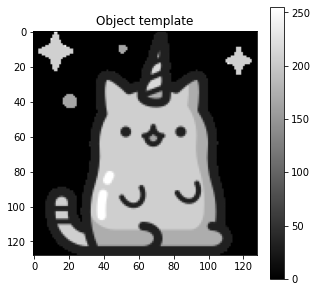

In [3]:
template = cv2.imread(os.path.join('asset', TEMPLATE_NAME, 'template.png'), 0)
print(template.shape)
fig, axarr = plt.subplots(1,1, figsize = (5,5))
pos1 = axarr.imshow(template, cmap = 'gray')
axarr.set_title("Object template")
fig.colorbar(pos1, ax=axarr)

In [4]:
test_dir = os.path.join('asset', TEMPLATE_NAME)
test_files = sorted(list(filter(lambda x: "test" in x, os.listdir(test_dir))))
N_TEST_IMG = len(test_files)
print("# Test img: %d"%N_TEST_IMG, " , list file", test_files)

# Test img: 5  , list file ['test1.png', 'test2.png', 'test3.png', 'test4.png', 'test5.png']


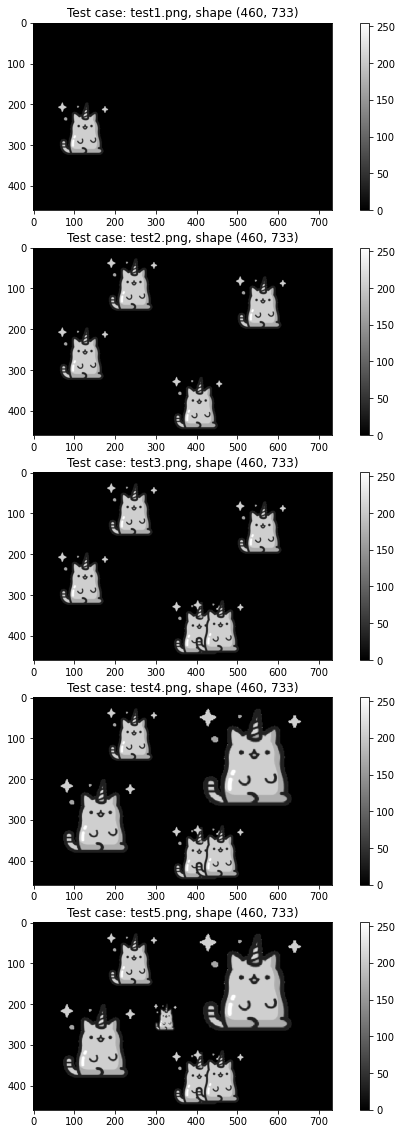

In [5]:
imgs = [
    cv2.imread(os.path.join(test_dir, test_file), 0)
    for test_file in test_files
]

fig, axarr = plt.subplots(N_TEST_IMG, 1, figsize=(10, 20))
for i, test_file, img in zip(range(N_TEST_IMG), test_files, imgs):
    pos1 = axarr[i].imshow(img, cmap = 'gray')
    axarr[i].set_title("Test case: {}, shape {}".format(test_file, img.shape))
    fig.colorbar(pos1, ax=axarr[i])

### 2D-Cross Correlaion

Given that a localized normalized 2D cross correlation in location $i,j$ as

\begin{equation*}
c(i, j) = \frac{\sum_{k, l} (F(k, l)-\bar{F}_{ij})(T(k, l) - \bar{T})}{\sqrt{\sum_{k,l}[F(k, l)-\bar{F}_{ij}]^2\sum_{k,l}[T(k, l) - \bar{T}]^2}}
\end{equation*}

where
- $F(k, l)$ sub image
- $T(k, l)$ template
- $\bar{F}_{ij}$ localized mean of sub image
- $\bar{T}$ mean of template

and dimension of $F(k, l)$ and $T(k, l) $ has to be the same

**Reference OpenCV Matching Template** https://docs.opencv.org/master/df/dfb/group__imgproc__object.html#gga3a7850640f1fe1f58fe91a2d7583695daf9c3ab9296f597ea71f056399a5831da

In [6]:
def cross_corr(
        _img: np.array, _template: np.array, is_custom_fn: bool= False
    ) -> np.array:
    _w, _h = _img.shape
    _k, _l = _template.shape
    _w_left = _k//2 - 1
    _w_right = _k//2
    _h_bottom = _l//2 - 1
    _h_top = _l//2

    _padded_img = cv2.copyMakeBorder(
        _img, 
        _h_top, _h_bottom, _w_left, _w_right,
        cv2.BORDER_CONSTANT,
        value=0
    )
    if not is_custom_fn:
        _cross_corr_img = cv2.matchTemplate(_padded_img, _template, method=cv2.TM_CCOEFF_NORMED)
    else:
        def pad_cross_cor(__sub_img: np.array, __template: np.array) -> float:
            assert __sub_img.shape == __template.shape
            __mean_sub_img = np.mean(__sub_img)
            __mean_template = np.mean(__template)
            __shift_sub_img = np.subtract(__sub_img, __mean_sub_img)
            __shift_template = np.subtract(__template, __mean_template)
            __corr = np.sum(np.multiply(
                __shift_sub_img,
                __shift_template
            ))
            if abs(__corr) < 1e-6:
                return 0.0
            __norm = math.sqrt(np.sum(np.square(__shift_sub_img)) * np.sum(np.square(__shift_template)))
            __normed_corr = __corr / __norm
            return __normed_corr
        
        _cross_corr_img = np.zeros(_img.shape)
        for j in range(_w):
            jp = j + _h_top
            for i in range(_h):
                ip = i + _w_left
                _cross_corr_img[j, i] = pad_cross_cor(
                    _padded_img[jp - _h_top: jp + _h_bottom + 1, ip - _w_left: ip + _w_right + 1],
                    _template
                )
    return _cross_corr_img

In [7]:
corrs = [cross_corr(img, template, is_custom_fn=True) for img in imgs]

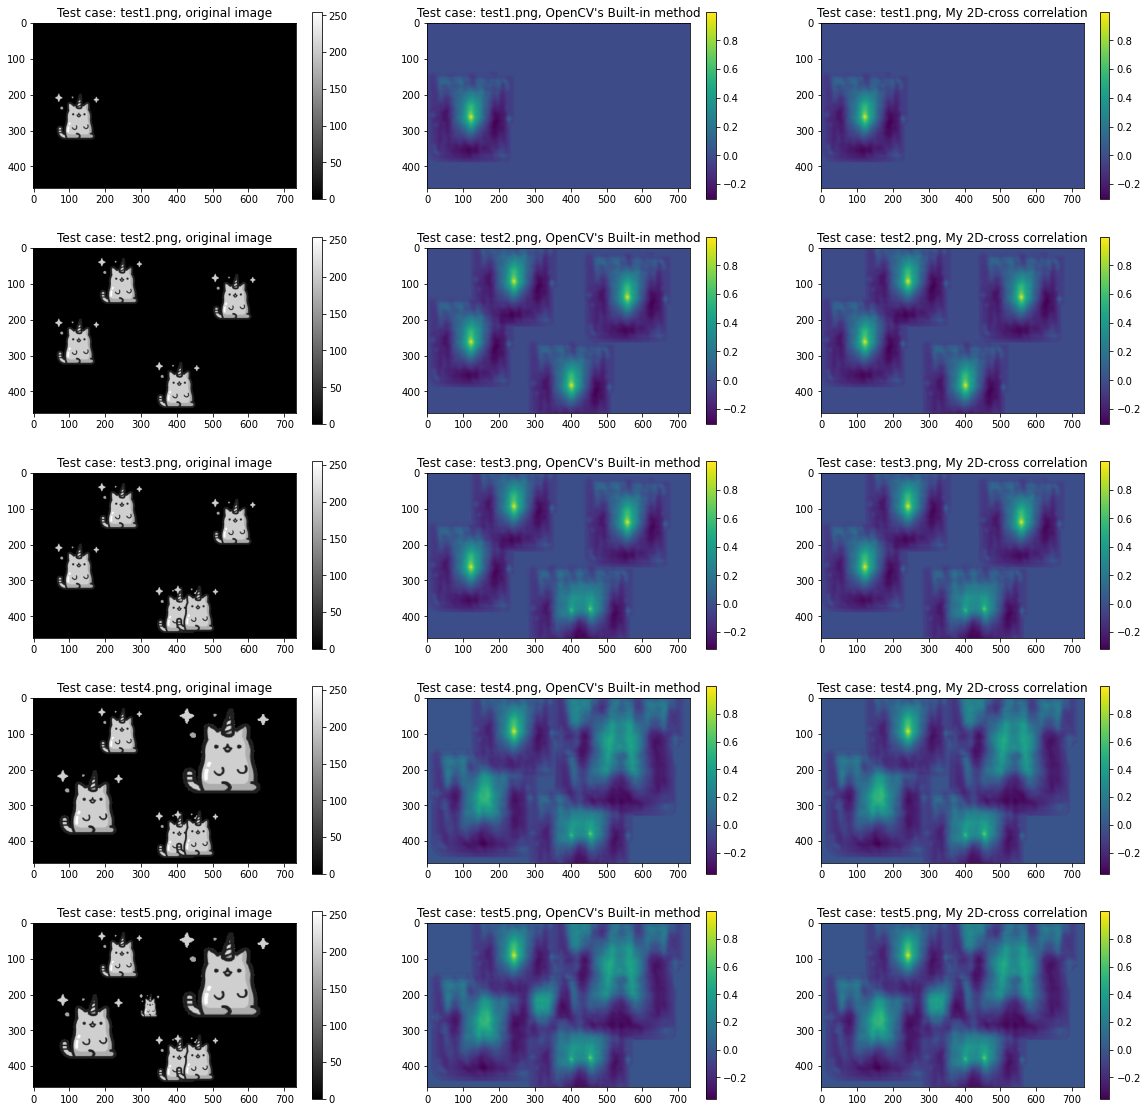

In [8]:
fig, axarr = plt.subplots(N_TEST_IMG, 3, figsize = (20,20))

builtin_corrs = [cross_corr(img, template, is_custom_fn=False) for img in imgs]
custom_corrs = [cross_corr(img, template, is_custom_fn=False) for img in imgs]

for i, test_file, img, builtin_corr, custom_corr in zip(
        range(N_TEST_IMG), test_files, imgs, builtin_corrs, custom_corrs
    ):
    pos_org = axarr[i, 0].imshow(img, cmap = 'gray')
    fig.colorbar(pos_org, ax=axarr[i, 0])
    axarr[i, 0].set_title("Test case: {}, original image".format(test_file))
    pos_corr = axarr[i, 1].imshow(builtin_corr, cmap = 'viridis')
    fig.colorbar(pos_corr, ax=axarr[i, 1])
    axarr[i, 1].set_title("Test case: {}, OpenCV's Built-in method".format(test_file))
    pos_corr = axarr[i, 2].imshow(custom_corr, cmap = 'viridis')
    fig.colorbar(pos_corr, ax=axarr[i, 2])
    axarr[i, 2].set_title("Test case: {}, My 2D-cross correlation".format(test_file))

#### Comparing built-in OpenCV method with custom function

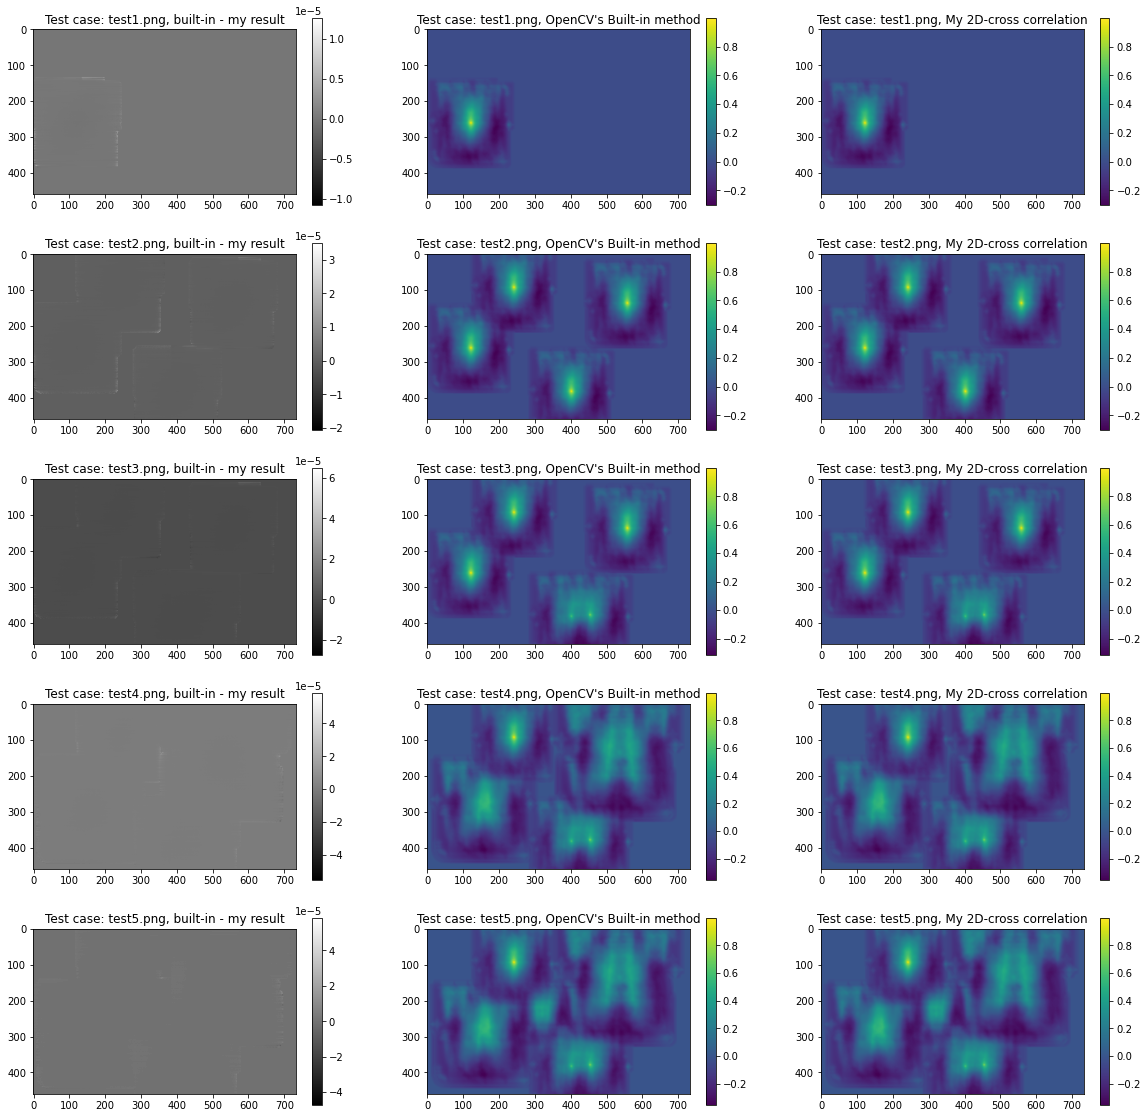

In [9]:
fig, axarr = plt.subplots(N_TEST_IMG, 3, figsize = (20,20))

builtin_corrs = [cross_corr(img, template, is_custom_fn=False) for img in imgs]

for i, test_file, img, builtin_corr in zip(
        range(N_TEST_IMG), test_files, imgs, builtin_corrs
    ):
    custom_corr = cross_corr(img, template, is_custom_fn=True)
    diff = np.subtract(builtin_corr, custom_corr)
    axarr[i, 0].set_title("Test case: {}, built-in - my result".format(test_file))
    pos_org = axarr[i, 0].imshow(diff, cmap = 'gray')
    fig.colorbar(pos_org, ax=axarr[i, 0])
    pos_corr = axarr[i, 1].imshow(builtin_corr, cmap = 'viridis')
    axarr[i, 1].set_title("Test case: {}, OpenCV's Built-in method".format(test_file))
    fig.colorbar(pos_corr, ax=axarr[i, 1])
    pos_corr = axarr[i, 2].imshow(custom_corr, cmap = 'viridis')
    fig.colorbar(pos_corr, ax=axarr[i, 2])
    axarr[i, 2].set_title("Test case: {}, My 2D-cross correlation".format(test_file))

## 1. Extrema Detection from scratch

In [10]:
OBJ_W = max(template.shape)//2 + 1 if max(template.shape)//2 % 2 == 0 else max(template.shape)//3 # pixel
OBJ_W

65

In [11]:
CORR_CUTOFF_THRS = 0.2
NMS_THRS = 0.2

In [12]:
def check_local_minimum(_sub_img: np.array) -> (tuple, typing.Union[int, float]):
    _center_i, _center_j = _sub_img.shape[0]//2, _sub_img.shape[1]//2
    _center_val = _sub_img[_center_i, _center_j]
    _max_val = np.max(_sub_img)
    _n_max_val = np.count_nonzero(np.equal(_max_val, _sub_img))
    if _n_max_val > 1:
        return False, _max_val
    _max_ind = np.unravel_index(np.argmax(_sub_img, axis=None), _sub_img.shape)
    _is_local_minimum_center = ((_center_i, _center_j) == _max_ind)
    return _is_local_minimum_center, _max_val

test_cases = [
    {
        "x": np.array([[1,1,1],[1,2,3], [1,1,1]]),
        "y": False
    },
    {
        "x": np.array([[1,1,1],[1,3,2], [1,1,1]]),
        "y": True
    },
    {
        "x": np.array([[1,6,1,1,1],[1,2,7,1,1], [1,1,1, 6,1]]),
        "y": True
    },
    {
        "x": np.array([[1,6,1,1,1],[1,2,3,1,1], [1,1,1, 6,1]]),
        "y": False
    },
    {
        "x": np.array([[1,6,1,1,1],[1,2,7,1,1], [7,1,1, 6,1]]),
        "y": False
    },
]

for i, test_case in enumerate(test_cases):
    try:
        is_local_minimum_center, score = check_local_minimum(test_case["x"])
        assert is_local_minimum_center == test_case["y"]
        print("Test case %d pass"%(i+1))
    except Exception as e:
        print("Test case %d fail"%(i+1))

Test case 1 pass
Test case 2 pass
Test case 3 pass
Test case 4 pass
Test case 5 pass


In [13]:
def find_local_minima(
        _corr_img: np.array, _window_w: int = OBJ_W,
        _cutoff_score: float = CORR_CUTOFF_THRS
    ) -> np.array:
    _window_hw = OBJ_W//2
    _w = _corr_img.shape[1]
    _h = _corr_img.shape[0]
    _obj_locations = []
    for i in range(_window_hw, _w - _window_hw):
        for j in range(_window_hw, _h - _window_hw):
            _is_local_minima, score = check_local_minimum(
                _corr_img[j - _window_hw: j + _window_hw, i - _window_hw: i + _window_hw]
            )
            if _is_local_minima and score >= _cutoff_score:
                _obj_locations.append((j, i, score))
    return _obj_locations

In [27]:
def nms(dets, thresh):
    """
    greedily select boxes with high confidence and overlap with current maximum <= thresh
    rule out overlap >= thresh
    :param dets: [[x1, y1, x2, y2 score]]
    :param thresh: retain overlap < thresh
    :return: indexes to keep
    
    https://github.com/TuSimple/simpledet/blob/master/operator_py/nms.py
    """
    x1 = dets[:, 0]
    y1 = dets[:, 1]
    x2 = dets[:, 2]
    y2 = dets[:, 3]
    scores = dets[:, 4]

    areas = (x2 - x1 + 1) * (y2 - y1 + 1)
    order = scores.argsort()[::-1]

    keep = []
    while order.size > 0:
        i = order[0]
        keep.append(i)
        xx1 = np.maximum(x1[i], x1[order[1:]])
        yy1 = np.maximum(y1[i], y1[order[1:]])
        xx2 = np.minimum(x2[i], x2[order[1:]])
        yy2 = np.minimum(y2[i], y2[order[1:]])

        w = np.maximum(0.0, xx2 - xx1 + 1)
        h = np.maximum(0.0, yy2 - yy1 + 1)
        inter = w * h
        ovr = inter / (areas[i] + areas[order[1:]] - inter)

        inds = np.where(ovr <= thresh)[0]
        order = order[inds + 1]

    return dets[keep, :]

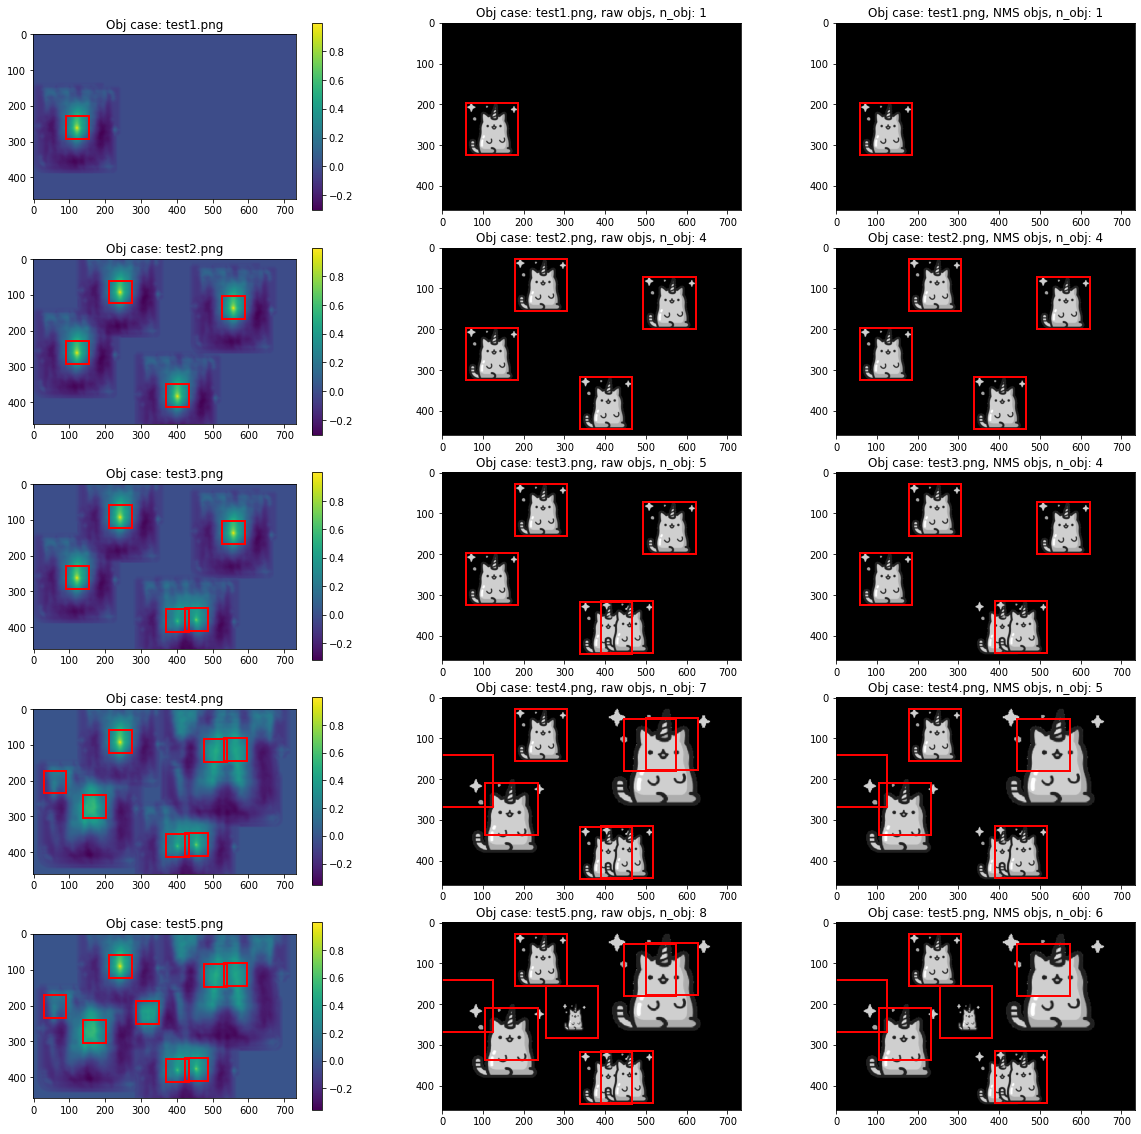

In [28]:
w = max(template.shape)

fig, axarr = plt.subplots(N_TEST_IMG, 3, figsize=(20, 20))
for i, test_file, img, corr in zip(range(N_TEST_IMG), test_files, imgs, corrs):
    pos1 = axarr[i, 0].imshow(corr, cmap = 'viridis')
    axarr[i, 0].set_title("Obj case: {}".format(test_file))
    fig.colorbar(pos1, ax=axarr[i, 0])
    obj_locations = find_local_minima(corr)
    for obj_location in obj_locations:
        sq = plt.Rectangle(
            (obj_location[1]-w/4, obj_location[0]-w/4), w/2, w/2,
            color="red", linewidth=2, fill=False
        )
        axarr[i, 0].add_patch(sq)
    ## Plot Raw Obj
    obj_xy_locations = np.array([
        [loc[0] - w/2, loc[1] - w/2, loc[0] + w/2, loc[1] + w/2, loc[2]]
        for loc in obj_locations
    ])
    n_raw_obj = len(obj_xy_locations)
    pos1 = axarr[i, 1].imshow(img, cmap = 'gray')
    axarr[i, 1].set_title("Obj case: {}, raw objs, n_obj: {}".format(test_file, n_raw_obj))
    for obj_xy_location in obj_xy_locations:
        sq = plt.Rectangle(
            (obj_xy_location[1], obj_xy_location[0]),
            abs(obj_xy_location[3] - obj_xy_location[1]),
            abs(obj_xy_location[2] - obj_xy_location[0]),
            color="red", linewidth=2, fill=False
        )
        axarr[i, 1].add_patch(sq)
    ## Plot Obj with NMS
    nms_obj_xy_locations = nms(obj_xy_locations, NMS_THRS)
    n_nms_obj = len(nms_obj_xy_locations)
    pos1 = axarr[i, 2].imshow(img, cmap = 'gray')
    axarr[i, 2].set_title("Obj case: {}, NMS objs, n_obj: {}".format(test_file, n_nms_obj))
    for nms_obj_xy_location in nms_obj_xy_locations:
        sq = plt.Rectangle(
            (nms_obj_xy_location[1], nms_obj_xy_location[0]),
            abs(nms_obj_xy_location[3] - nms_obj_xy_location[1]),
            abs(nms_obj_xy_location[2] - nms_obj_xy_location[0]),
            color="red", linewidth=2, fill=False
        )
        axarr[i, 2].add_patch(sq)

## 2. Extrema Detection usig DoG

In [72]:
MIN_SIGMA = min(template.shape)/4
MAX_SIGMA = max(template.shape)



In [73]:
from skimage.feature import blob_dog

localized_objs_list = [
    blob_dog(corr, min_sigma=MIN_SIGMA, max_sigma=MAX_SIGMA)
    for corr in corrs
]

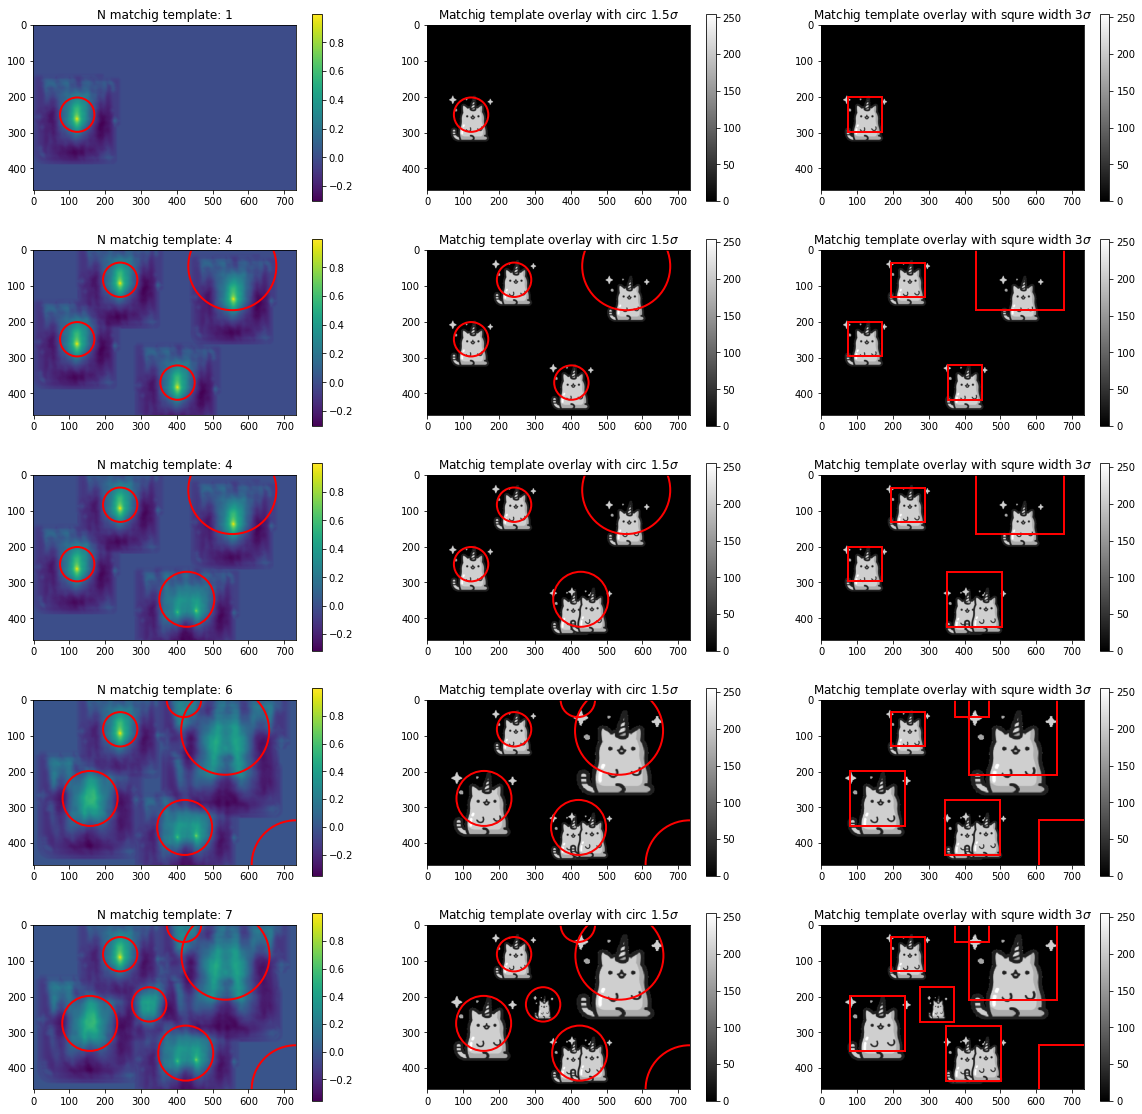

In [74]:
fig, axarr = plt.subplots(N_TEST_IMG, 3, figsize = (20,20))

for i, test_file, img, corr, localized_objs in zip(range(N_TEST_IMG), test_files, imgs, corrs, localized_objs_list):
    n_obj = len(localized_objs)
    pos_corr = axarr[i, 0].imshow(corr, cmap = 'viridis')
    fig.colorbar(pos_corr, ax=axarr[i, 0])
    axarr[i, 0].set_title("N matchig template: %d"%n_obj)
    
    pos_org = axarr[i, 1].imshow(img, cmap = 'gray')
    fig.colorbar(pos_org, ax=axarr[i, 1])
    axarr[i, 1].set_title("Matchig template overlay with circ 1.5$\sigma$")
    
    pos_org = axarr[i, 2].imshow(img, cmap = 'gray')
    fig.colorbar(pos_org, ax=axarr[i, 2])
    axarr[i, 2].set_title("Matchig template overlay with squre width 3$\sigma$")
    
    for localized_obj in localized_objs:
        y, x, r = localized_obj
        c = plt.Circle((x, y), 1.5*r, color="red", linewidth=2, fill=False)
        axarr[i, 0].add_patch(c)
        c = plt.Circle((x, y), 1.5*r, color="red", linewidth=2, fill=False)
        axarr[i, 1].add_patch(c)
        sq = plt.Rectangle((x-1.5*r, y-1.5*r), 3*r, 3*r, color="red", linewidth=2, fill=False)
        axarr[i, 2].add_patch(sq)

## Rooms for Improvement
- Distortion of the template (e.g. Rotation and sizing)
- Problem of overlaping obj still does not solve yet
- Symmetric image (like docker) has a problem when determining by using DoG